In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np

In [2]:
batch_size = 100
img_sz = 28
img_len = img_sz*img_sz
n_itr = 50000
n_class = 10
lstm_size = 256
T = 10
A = img_sz
B = img_sz
eps = 1e-7
N = 5
lr = 1e-3

In [10]:
# calculate F_x and F_y
def get_Fx_Fy(h):
    params = tf.matmul(h, params_W) + params_b
    g_x_, g_y_, log_var_Fxy, log_delta_, log_gamma = tf.split(params, num_or_size_splits=5, axis=1)
    var_Fxy = tf.exp(log_var_Fxy)
    gamma = tf.exp(log_gamma)
    
    g_x = ((A + 1) * 0.5) * (g_x_ + 1)
    g_y = ((B + 1) * 0.5) * (g_y_ + 1)
    delta = ((max(A, B) - 1) / (N - 1)) * tf.exp(log_delta_)

    filter_i = tf.reshape(tf.cast(tf.range(N), tf.float32), [1, -1])
    mu_x = g_x + (filter_i - N / 2 - 0.5) * delta
    mu_y = g_y + (filter_i - N / 2 - 0.5) * delta

    a = tf.reshape(tf.cast(tf.range(A), tf.float32), [1, 1, -1])
    b = tf.reshape(tf.cast(tf.range(B), tf.float32), [1, 1, -1])
    mu_x = tf.reshape(mu_x, [-1, N, 1])
    mu_y = tf.reshape(mu_y, [-1, N, 1])
    var_Fxy = tf.reshape(var_Fxy, [-1, 1, 1])    
    
    F_x = tf.exp(-tf.square((a - mu_x) / (2 * var_Fxy)))
    F_y = tf.exp(-tf.square((b - mu_y) / (2 * var_Fxy))) 
    
    F_x = F_x / tf.maximum(tf.reduce_sum(F_x, 2, keep_dims=True), eps)
    F_y = F_y / tf.maximum(tf.reduce_sum(F_y, 2, keep_dims=True), eps)
    return (F_x, F_y, gamma)

In [4]:
def read(r, F_x, F_y, gamma):
    # (F_x.T r F_y) * gamma
    r = tf.reshape(r, [-1, B, A])
    F_x_transpose = tf.transpose(F_x, perm=[0,2,1])
    r = tf.matmul(F_y, tf.matmul(r, F_x_transpose))
    r = tf.reshape(r, [-1, N*N])
    r = r * tf.reshape(gamma,[-1,1])
    return r

In [5]:
def write(w, F_x, F_y, gamma):
    # (F_y.T w_ F_x) / gamma
    w = tf.reshape(w, [batch_size, N, N])
    F_y_transpose = tf.transpose(F_y, perm=[0,2,1])
    w = tf.matmul(F_y_transpose, tf.matmul(w, F_x))
    w = tf.reshape(w, [batch_size, B*A])
    w = w * tf.reshape(1.0/gamma,[-1,1])
    return w

In [7]:
x = tf.placeholder(tf.float32, [batch_size, img_len])
y_ = tf.placeholder(tf.float32, [batch_size, n_class])

rnn_enc = tf.contrib.rnn.LSTMCell(lstm_size)
rnn_dec = tf.contrib.rnn.LSTMCell(lstm_size)

write_W = tf.Variable(tf.zeros([lstm_size, N*N]))
write_b = tf.Variable(tf.zeros([N*N]))

mu_W = tf.Variable(tf.zeros([lstm_size, n_class]))
mu_b = tf.Variable(tf.zeros([n_class]))

log_sigma_W = tf.Variable(tf.zeros([lstm_size, n_class]))
log_sigma_b = tf.Variable(tf.zeros([n_class]))

params_W = tf.Variable(tf.zeros([lstm_size, 5]))
params_b = tf.Variable(tf.zeros([5]))

In [13]:
c0 = tf.zeros([batch_size, img_len], dtype=tf.float32)
#h0_enc = tf.zeros([batch_size, lstm_size], dtype=tf.float32)
h0_dec = tf.zeros([batch_size, lstm_size], dtype=tf.float32)

c = [0]*T
#h_enc = h0_enc
h_dec = h0_dec
state_enc = rnn_enc.zero_state(batch_size, tf.float32) 
state_dec = rnn_dec.zero_state(batch_size, tf.float32) 

Lz_list = [0]*T

F_x, F_y, gamma = get_Fx_Fy(h_dec)
# read
for t in range(T):
    c_prev = c0 if t==0 else c[t-1]
    #read
    x_hat = x - tf.sigmoid(c_prev)
    # no atten
    #r = tf.concat(1,[x, x_hat])
    r_x = read(x, F_x, F_y, gamma)
    r_x_hat = read(x_hat, F_x, F_y, gamma)
    r = tf.concat([r_x, r_x_hat], axis=1)
    
    #encoder
    x_enc = tf.concat([r, h_dec], axis=1)
    with tf.variable_scope("encoder", reuse=(t != 0)):
        h_enc, state_enc = rnn_enc(x_enc, state_enc)

    # sample Q
    mu_Q = tf.matmul(h_enc, mu_W) + mu_b
    log_sigma_Q = tf.matmul(h_enc, log_sigma_W) + log_sigma_b
    sigma_Q = tf.exp(log_sigma_Q)
    std_normal = tf.random_normal([batch_size, n_class], mean=0, stddev=1)
    z = mu_Q + std_normal*sigma_Q
    
    # variational loss
    sigma_Q_sq = tf.square(sigma_Q)
    mu_Q_sq = tf.square(mu_Q)
    Lz_list[t] = 0.5 * tf.reduce_sum(mu_Q_sq + sigma_Q_sq - 2*log_sigma_Q,1) - 0.5
                 
    # decoder
    with tf.variable_scope("decoder", reuse=(t != 0)):
        h_dec, state_dec = rnn_dec(z, state_dec) 
    
    # no atten
    w = tf.matmul(h_dec, write_W) + write_b
        
    #write       
    F_x, F_y, gamma = get_Fx_Fy(h_dec)
    w = write(w, F_x, F_y, gamma)
                 
    c[t] = c_prev + w

In [14]:
# reconstruction loss
x_recons = tf.sigmoid(c[-1])
# binary cross entropy
Lx = tf.reduce_sum((x * tf.log(x_recons + eps) + (1.0 - x) * tf.log(1.0 - x_recons + eps)), 1)
Lx = -tf.reduce_mean(Lx)

#KL divergence
Lz = tf.add_n(Lz_list)
Lz = tf.reduce_mean(Lz)

# Loss
KL divergence between auxialary distr q and real distr $p_\ast$
$$KL[p_\ast||q] = \sum_{{x} \thicksim {p}} {p_\ast(x)\log \frac{p_\ast(x)}{q(x)}}$$
$p_\ast$ is untractable so we can't sample form it. 
Hence we calculate reverse KL divergence, as q is tractable.

$$KL[q||p_\ast] = \sum_{{x} \thicksim {q}} {q(x)\log \frac {q(x)}{p_\ast(x)}} $$
claculating $p_\ast{x} = p(x|D)$ pointwise (for data D) is hard because it needs 
$Z = p(D)$ which is again untractable.

un-normalized conditional prob is generally tractable to compute.
$$\tilde{p}(x) \triangleq p(x, D) = p_\ast(x)Z$$

So we write new objective as (abusing the notation because $\tilde{p}(x)$ is not a normalize dist.
$$J(q) \triangleq KL[q||\tilde{p}(x)]$$

$$J(q) = \sum_{{x} \thicksim {q}} {q(x)\log \frac {q(x)}{\tilde{p}(x)}} = \sum_{{x} \thicksim {q}} {q(x)\log \frac {q(x)}{Zp_\ast(x)}} = \sum_{{x} \thicksim {q}} {q(x)\log \frac {q(x)}{p_\ast(x)}} - \log{Z} = KL[q||p_\ast] - \log{Z}$$

Where $Z$ is a constant. By minimizing $J(q)$ we make q to be closer to $p_\ast$
Since KL divergence is always +ve we see that $J(q)$ is an upper bound on negative 
log likelihood on the data D which we would like to minimize.
$$J(q)     = KL[q||p_\ast] - \log{Z} > - \log{Z} = - \log{p(D)}$$

So we want to maximize $-J(q)$ which is lower bound on log likelihood of data.
which is also variational lower bound.

In [15]:
loss = Lx + Lz
optimizer = tf.train.AdamOptimizer(learning_rate=lr, beta1=0.5)
grads_and_vars = optimizer.compute_gradients(loss)
capped_grads_and_vars = [(tf.clip_by_norm(grad, 5.), var) for grad, var in grads_and_vars]
train_step = optimizer.apply_gradients(capped_grads_and_vars)

In [22]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
ckpt_file= "saved_models/draw_model.ckpt"

saver.restore(sess, ckpt_file)
print("Model restored")

#tf.global_variables_initializer().run()
recon_loss = np.zeros(n_itr)
variation_loss = np.zeros(n_itr)

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

for i in range(n_itr):
    batch_xs, _ = mnist.train.next_batch(batch_size)
    recon_loss[i], variation_loss[i], _= sess.run([Lx, Lz, train_step], feed_dict={x: batch_xs})
    
    if i%100==0:
        print("iter=%d : Lx: %f Lz: %f" % (i,recon_loss[i], variation_loss[i]))

Model restored
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
iter=0 : Lx: 75.708672 Lz: 64.760284
iter=100 : Lx: 73.132874 Lz: 64.634972
iter=200 : Lx: 71.997284 Lz: 64.542877
iter=300 : Lx: 77.275383 Lz: 65.364449
iter=400 : Lx: 71.289543 Lz: 65.495804
iter=500 : Lx: 75.388298 Lz: 65.180344
iter=600 : Lx: 74.669502 Lz: 65.396561
iter=700 : Lx: 76.095512 Lz: 65.364647
iter=800 : Lx: 73.296471 Lz: 64.952614
iter=900 : Lx: 77.405983 Lz: 65.647217
iter=1000 : Lx: 76.378937 Lz: 65.284637
iter=1100 : Lx: 72.227089 Lz: 64.749382
iter=1200 : Lx: 72.550301 Lz: 64.705276
iter=1300 : Lx: 73.402435 Lz: 65.075958
iter=1400 : Lx: 72.954384 Lz: 64.844948
iter=1500 : Lx: 73.276512 Lz: 65.215736
iter=1600 : Lx: 71.965782 Lz: 65.296249
iter=1700 : Lx: 74.744614 Lz: 65.266754
iter=1800 : Lx: 77.390320 Lz: 65.563553
iter=1900 : Lx: 75.504601 Lz: 65.250420
ite

KeyboardInterrupt: 

In [17]:
batch_xs, _ = mnist.train.next_batch(batch_size)
output_images = sess.run(c, feed_dict={x: batch_xs}) 
output_images = np.array(output_images) 

out_file="draw_data.npy"
np.save(out_file,[output_images, recon_loss, variation_loss])
print("Outputs saved in file: %s" % out_file)

ckpt_file= "saved_models/draw_model.ckpt"
print("Model saved in file: %s" % saver.save(sess, ckpt_file))

sess.close()

Outputs saved in file: draw_data.npy
Model saved in file: saved_models/draw_model.ckpt


In [18]:
import matplotlib
import sys
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

def xrecons_grid(X,B,A):
    padsize=1
    padval=.5
    ph=B+2*padsize
    pw=A+2*padsize
    batch_size=X.shape[0]
    N=int(np.sqrt(batch_size))
    X=X.reshape((N,N,B,A))
    img=np.ones((N*ph,N*pw))*padval
    for i in range(N):
        for j in range(N):
            startr=i*ph+padsize
            endr=startr+B
            startc=j*pw+padsize
            endc=startc+A
            img[startr:endr,startc:endc]=X[i,j,:,:]
    return img

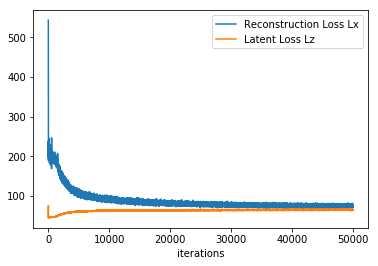

In [19]:
out_file="draw_data.npy"
[C,Lxs,Lzs]=np.load(out_file)
T,batch_size,img_size=C.shape
X=1.0/(1.0+np.exp(-C)) 
B=A=int(np.sqrt(img_size))

plt.plot(Lxs,label='Reconstruction Loss Lx')
plt.plot(Lzs,label='Latent Loss Lz')
plt.xlabel('iterations')
plt.legend()

plt.show()

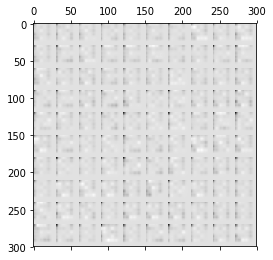

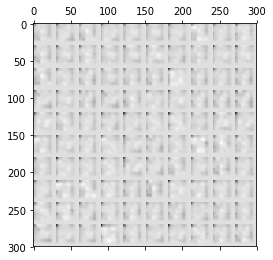

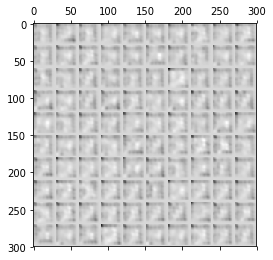

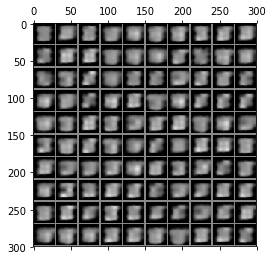

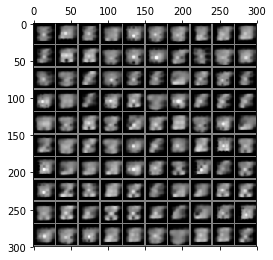

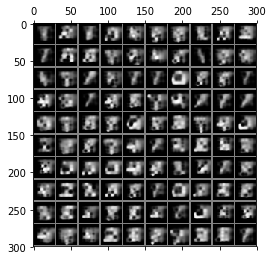

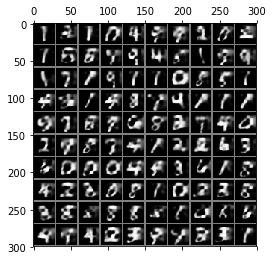

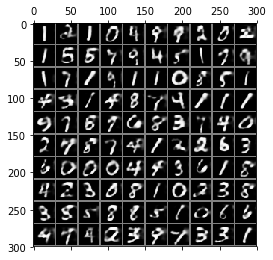

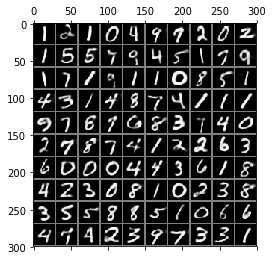

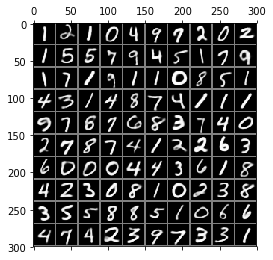

In [20]:
for t in range(T):
    img=xrecons_grid(X[t,:,:],B,A)
    plt.matshow(img,cmap=plt.cm.gray)
    ## convert -delay 10 -loop 0 *.png mnist.gif
    #imgname='img_%d.png' % ('images', t) 
    #plt.savefig(imgname)
    #print(imgname)


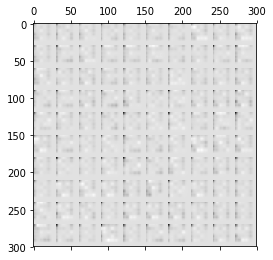

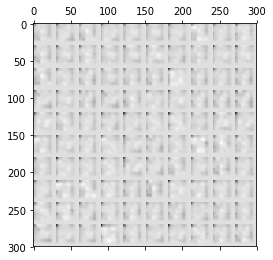

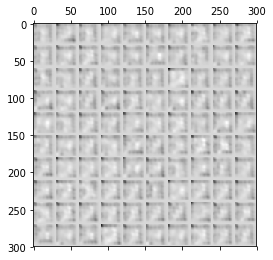

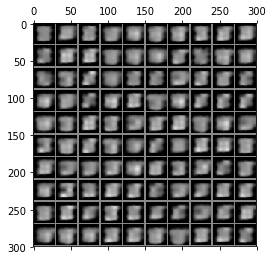

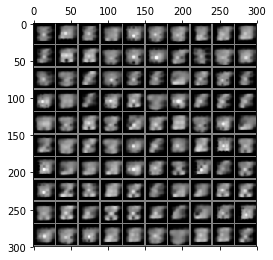

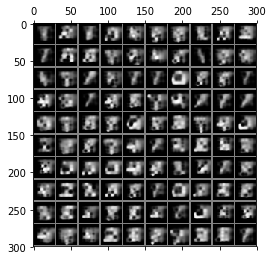

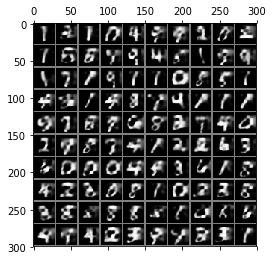

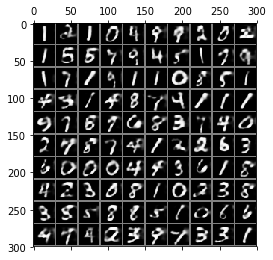

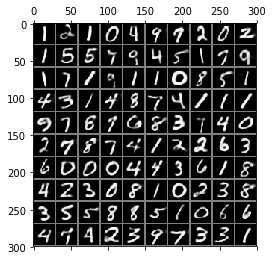

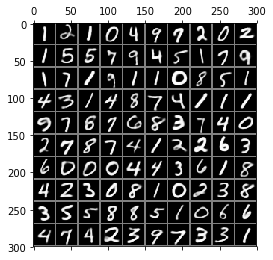

In [21]:
for t in range(T):
    img=xrecons_grid(X[t,:,:],B,A)
    plt.matshow(img,cmap=plt.cm.gray)